In [730]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 8, 4 # set default size of plots
plt.style.use('seaborn-whitegrid') # set style (colors, background, size, gridlines etc.) # ggplot
plt.rcParams.update({'font.size': 16}) 

import scraping_class
logfile = 'log.txt' ## name your log file.
connector = scraping_class.Connector(logfile)

from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [10]:
x = pd.read_csv("inputInfo_X.csv")
y = pd.read_csv("inputInfo_Y.csv")

In [103]:
# define features to be dropped from given dataset
imdb_features = ['metascore', 'director_metascore', 'writer_metascore', 'tomatometer_score', 'director_tomatometer','writer_tomatometer', 'audience_score', 'director_audience', 'writer_audience']
meta_features = ['avg_vote', 'director_imdb', 'writer_imdb', 'tomatometer_score', 'director_tomatometer','writer_tomatometer', 'audience_score', 'director_audience', 'writer_audience']
tomato_features = ['avg_vote', 'director_imdb', 'writer_imdb', 'metascore', 'director_metascore', 'writer_metascore', 'audience_score', 'director_audience', 'writer_audience'] 
audience_features = ['avg_vote', 'director_imdb', 'writer_imdb', 'metascore', 'director_metascore', 'writer_metascore', 'tomatometer_score', 'director_tomatometer','writer_tomatometer']

In [104]:
# construct datasets for desired features
x_imdb = x.drop(imdb_features,axis=1)
x_meta = x.drop(meta_features,axis=1)
x_tometer = x.drop(tomato_features,axis=1)
x_audience = x.drop(audience_features,axis=1)

# select target
y_wgi = y['adjusted_wgi']
y_norm = np.log(y_wgi) # log normalize

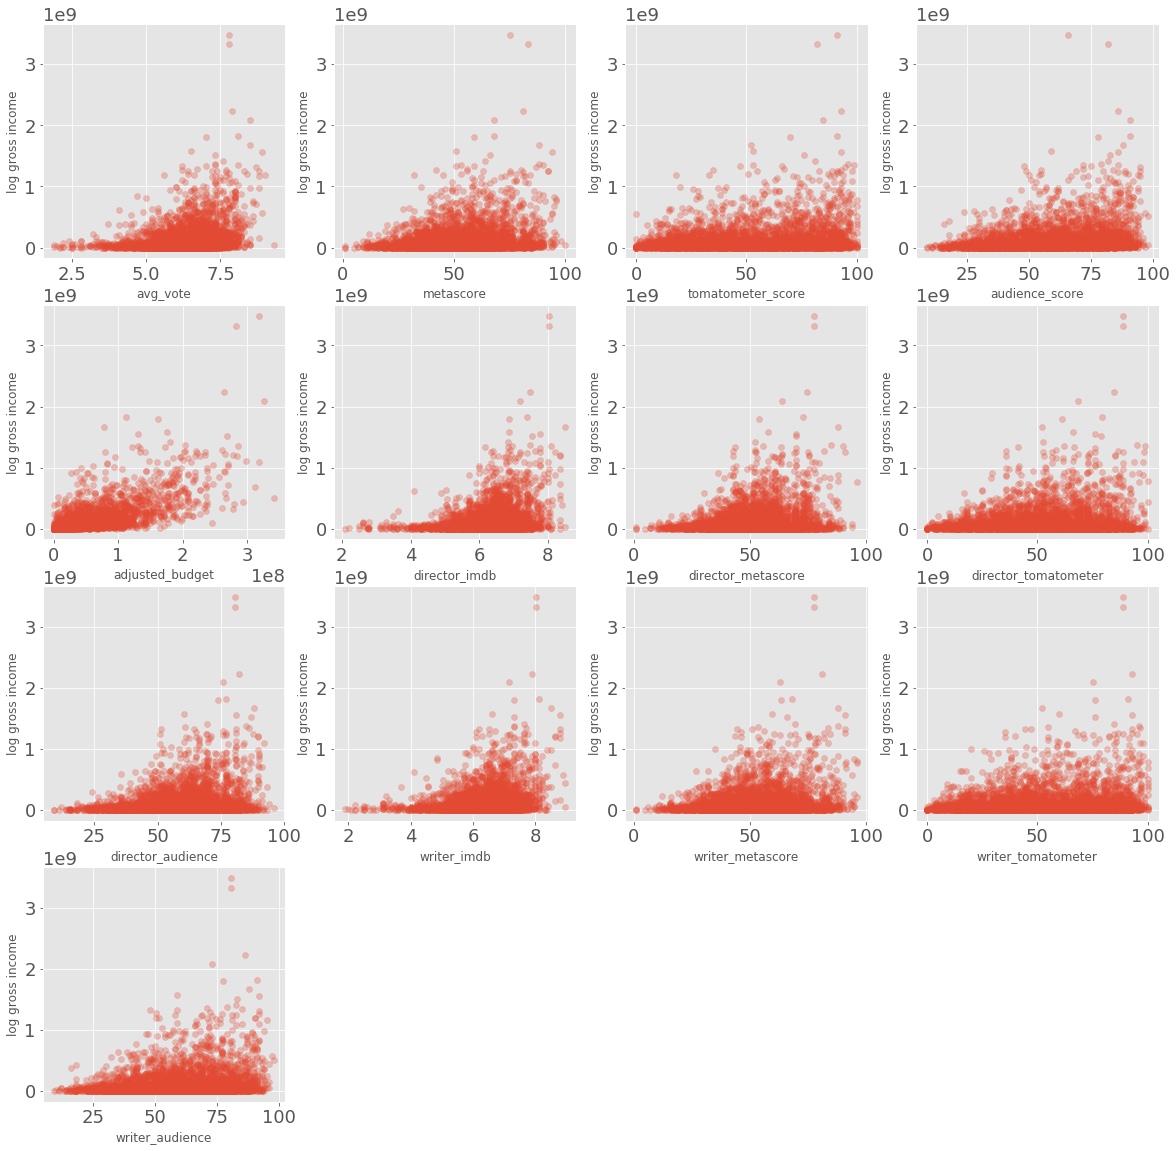

In [62]:
fig = plt.figure(figsize = (20, 25)) # create figure

for index, feature_name in enumerate(x.columns[:13]): # create scatterplot for each of the main features
    ax = fig.add_subplot(5, 4, index+1) 
    ax.scatter(x[feature_name], y_wgi, alpha=0.3) 
    ax.set_ylabel('log gross income', size = 12) 
    ax.set_xlabel(feature_name, size = 12) 
  
plt.show() 

Now we want to build a preliminary model to evaluate baseline performance of each of the datasets in a linear regression.

In [105]:
# split datasets into set for training and testing
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(x_imdb, y_norm, test_size=1/3, random_state=1)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(x_meta, y_norm, test_size=1/3, random_state=1)
X_train_tometer, X_test_tometer, y_train_tometer, y_test_tometer = train_test_split(x_tometer, y_norm, test_size=1/3, random_state=1)
X_train_audience, X_test_audience, y_train_audience, y_test_audience = train_test_split(x_audience, y_norm, test_size=1/3, random_state=1)

In [527]:
def lin_reg(X_train_,y_train_):
    'fits and predicts linear regression given train and test sets'
    lr = LinearRegression()
    lr.fit(X_train_, y_train_)

    pred_train_lr= lr.predict(X_train_)
    mse_ = mse(y_train_,pred_train_lr)
    r2_ = r2_score(y_train_, pred_train_lr)

    return mse_, r2_

In [725]:
imdb_reg = lin_reg(X_train_imdb,y_train_imdb)
meta_reg = lin_reg(X_train_meta,y_train_meta)
tomato_reg = lin_reg(X_train_tometer,y_train_tometer)
audience_reg = lin_reg(X_train_audience,y_train_audience)

In [726]:
print(imdb_reg)
print(meta_reg)
print(tomato_reg)
print(audience_reg)

(2.942633660884488, 0.5329007047294072)
(3.036290515164636, 0.5180340731085453)
(3.0938718899172195, 0.5208966829758526)
(2.880802431637698, 0.5427154920713725)


Now we try out different models for the **imdb** dataset and use this to select our model.

In [548]:
# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(x_imdb, y_norm, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

Implement cross validation on Lasso model using K-fold method

In [261]:
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))

lambdas =  np.logspace(-4, 6, 12) # set hyperparameter space

# outer loop: lambdas
mseCV_lasso = []
for lambda_ in tqdm(lambdas):    
    # inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # store result    
    mseCV_lasso.append(mseCV_) 
    
# convert to DataFrame
lambdaCV_lasso = pd.DataFrame(mseCV_lasso, index=lambdas)

In [720]:
# choose optimal hyperparameters 
optimal_lambda_lasso = lambdaCV_lasso.mean(axis=1).nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda_lasso.index[0], random_state=1))
pipe_lassoCV.fit(X_dev,y_dev)
score_lasso = mse(pipe_lassoCV.predict(X_test),y_test)
r2_lassoCV = r2_score(y_test, pipe_lassoCV.predict(X_test))
lasso_model = pipe_lassoCV.steps[2][1]

In [721]:
print('Optimal lambda in lasso model is:', optimal_lambda_lasso.index[0])
print('Resulting MSE and r2:', score_lasso, r2_lassoCV)
 # extract model from pipe
print('Lasso coefficients are:', lasso_model.coef_)

Optimal lambda in lasso model is: 0.4328761281083057
Resulting MSE and r2: 4.036790296866658 0.3306233224000097
Lasso coefficients are: [ 0.         0.8278526  0.        ... -0.         0.        -0.       ]


Implement cross validation on Ridge model using K-fold method.

In [253]:
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))

lambdas =  np.logspace(-4, 6, 12)

# outer loop: lambdas
mseCV_ridge = []
for lambda_ in tqdm(lambdas):    
    # inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_ridgeCV = make_pipeline(PolynomialFeatures(include_bias=False),
                                     StandardScaler(),
                                     Ridge(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        pipe_ridgeCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_ridgeCV.predict(X_val), y_val))    
        
    # store result    
    mseCV_ridge.append(mseCV_) 
    
# convert to DataFrame
lambdaCV_ridge = pd.DataFrame(mseCV_ridge, index=lambdas)

In [723]:
# choose optimal hyperparameter
optimal_lambda_ridge = lambdaCV_ridge.mean(axis=1).nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_ridgeCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Ridge(alpha=optimal_lambda_ridge.index[0], random_state=1))
pipe_ridgeCV.fit(X_dev,y_dev)
score_ridge = mse(pipe_ridgeCV.predict(X_test),y_test)
r2_ridgeCV = r2_score(y_test, pipe_ridgeCV.predict(X_test))
ridge_model = pipe_ridgeCV.steps[2][1]

In [724]:
print('Optimal lambda in ridge model is:', optimal_lambda_ridge.index[0])
print('Resulting MSE and r2:', score_ridge, r2_ridgeCV)
 # extract model from pipe
print('Ridge coefficients are:', ridge_model.coef_)

Optimal lambda in ridge model is: 15199.11082952933
Resulting MSE and r2: 4.090758582148029 0.3216743533328148
Ridge coefficients are: [ 0.03828336  0.10547015  0.02823943 ... -0.00431202  0.
 -0.01201692]


Now we plot the learning curves and validation curves for the Lasso and Ridge models

In [324]:
# set pipelines
pipe_ridge = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Ridge(random_state=1))

pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(random_state=1))

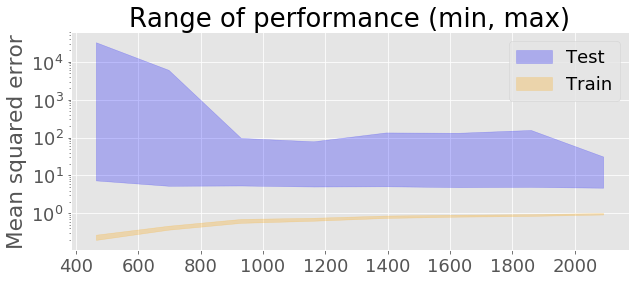

In [196]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.min(1),
                -test_scores.max(1), 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.min(1),
                -train_scores.max(1), 
                alpha=0.25, label='Train', color='orange')

ax.set_title('Range of performance (min, max)')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

In [358]:
def learn_curve_lasso(data):
    '''get learning curve values for lasso model'''
    
    # splitting into development (2/3) and test data (1/3)
    X_dev, X_test, y_dev, y_test = train_test_split(data, y_norm, test_size=1/3, random_state=1)

    # splitting development into train (1/3) and validation (1/3)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.2, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=5)

    return [train_sizes, train_scores, test_scores]


In [359]:
def learn_curve_ridge(data):
    '''get learning curve values for lasso model'''
    
    # splitting into development (2/3) and test data (1/3)
    X_dev, X_test, y_dev, y_test = train_test_split(data, y_norm, test_size=1/3, random_state=1)

    # splitting development into train (1/3) and validation (1/3)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_ridge,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.2, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=5)

    return [train_sizes, train_scores, test_scores]

In [619]:
def val_curve_lasso(data):
    '''get validation curve values for lasso model'''
    # splitting into development (2/3) and test data (1/3)
    X_dev, X_test, y_dev, y_test = train_test_split(data, y_norm, test_size=1/3, random_state=1)

    # splitting development into train (1/3) and validation (1/3)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    train_scores, test_scores = validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=5)

    mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
                        .set_index('lambda')
              
    return mse_score

In [620]:
def val_curve_ridge(data):
    '''get validation curve values for ridge model'''
    # splitting into development (2/3) and test data (1/3)
    X_dev, X_test, y_dev, y_test = train_test_split(data, y_norm, test_size=1/3, random_state=1)

    # splitting development into train (1/3) and validation (1/3)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    train_scores, test_scores = validation_curve(estimator=pipe_ridge,
                     X=X_dev,
                     y=y_dev,
                     param_name='ridge__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=5)

    mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
                        .set_index('lambda')
              
    return mse_score

In [689]:
mse_scores_learn_lasso = []

# retrieving values from each dataset
for data in tqdm([x_imdb,x_meta,x_tometer,x_audience]):
    mse_scores_learn_lasso.append(learn_curve_lasso(data))

In [621]:
mse_scores_val_lasso = []

# retrieving values from each dataset
for data in tqdm([x_imdb,x_meta,x_tometer,x_audience]):
    mse_scores_val_lasso.append(val_curve_lasso(data))

In [363]:
mse_scores_learn_ridge = []

# retrieving values from each dataset
for data in tqdm([x_imdb,x_meta,x_tometer,x_audience]):
    mse_scores_learn_ridge.append(learn_curve_ridge(data))

In [627]:
mse_scores_val_ridge = []

# retrieving values from each dataset
for data in tqdm([x_imdb,x_meta,x_tometer,x_audience]):
   mse_scores_val_ridge.append(val_curve_ridge(data))

In [738]:
def plot_learning_curve_lasso(i,row,col,data):
    
    train_sizes, train_scores, test_scores = mse_scores_learn_lasso[i][0], mse_scores_learn_lasso[i][1], mse_scores_learn_lasso[i][2]
    ax[row][col].plot(train_sizes,-test_scores.mean(1), alpha=0.8, linewidth=2, label ='Validation',color='green')
    ax[row][col].plot(train_sizes,-train_scores.mean(1),alpha=0.8, linewidth=2, label='Train')

    ax[row][col].set_title(data)
    ax[row][col].set_xlabel('train sizes')
    ax[row][col].set_ylabel('Mean squared error')
    ax[row][col].set_yscale('log')
    ax[row][col].legend()

In [739]:
def plot_learning_curve_ridge(i,row,col,data):
    
    train_sizes, train_scores, test_scores = mse_scores_learn_ridge[i][0], mse_scores_learn_ridge[i][1], mse_scores_learn_ridge[i][2]
    ax[row][col].plot(train_sizes,-test_scores.mean(1), alpha=0.8, linewidth=2, label ='Validation', color='green')
    ax[row][col].plot(train_sizes,-train_scores.mean(1),alpha=0.8, linewidth=2, label='Train')

    ax[row][col].set_title(data)
    ax[row][col].set_xlabel('train sizes')
    ax[row][col].set_ylabel('Mean squared error')
    ax[row][col].set_yscale('log')
    ax[row][col].legend()

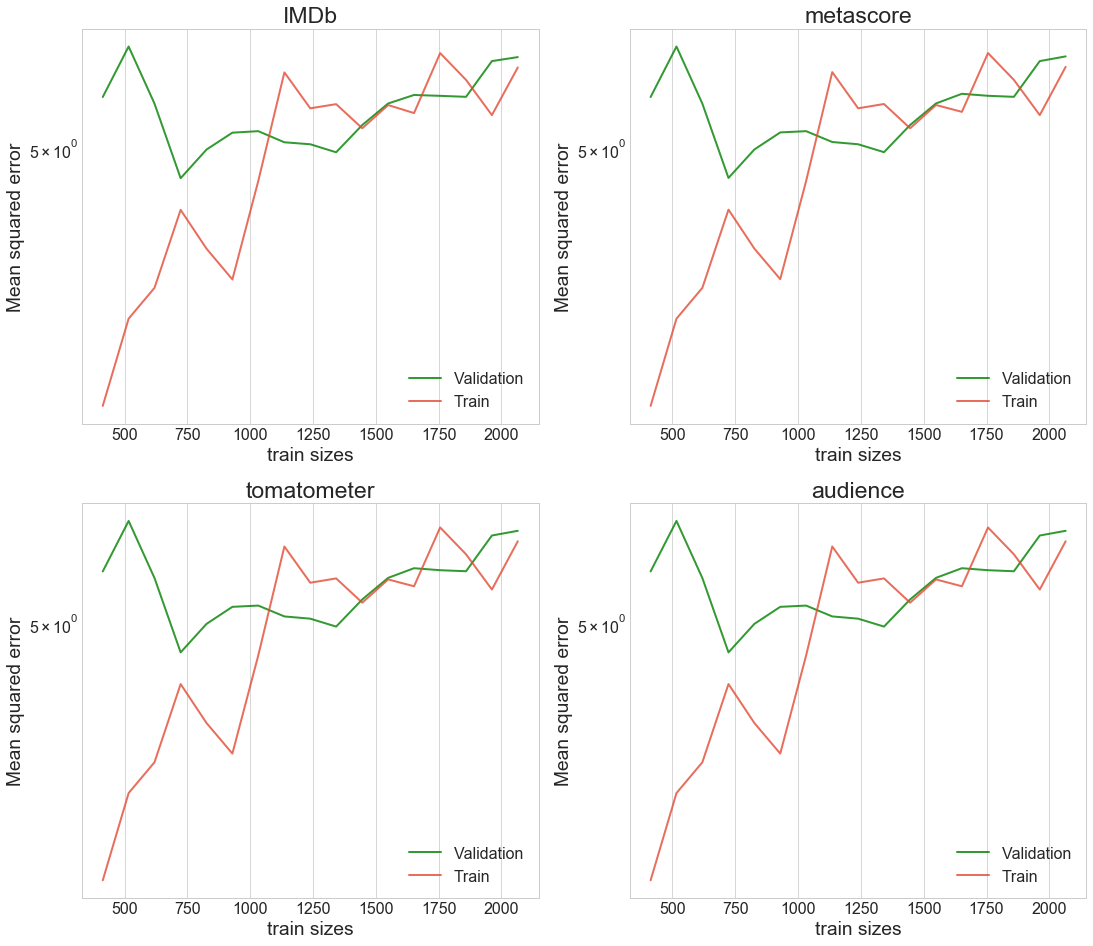

In [740]:
fig, ax = plt.subplots(2,2, figsize=(18,16))

plot_learning_curve_lasso(0,0,0,'IMDb')
plot_learning_curve_lasso(1,0,1,'metascore')
plot_learning_curve_lasso(2,1,0,'tomatometer')
plot_learning_curve_lasso(3,1,1,'audience')

plt.savefig('learn_lasso_comb.png')

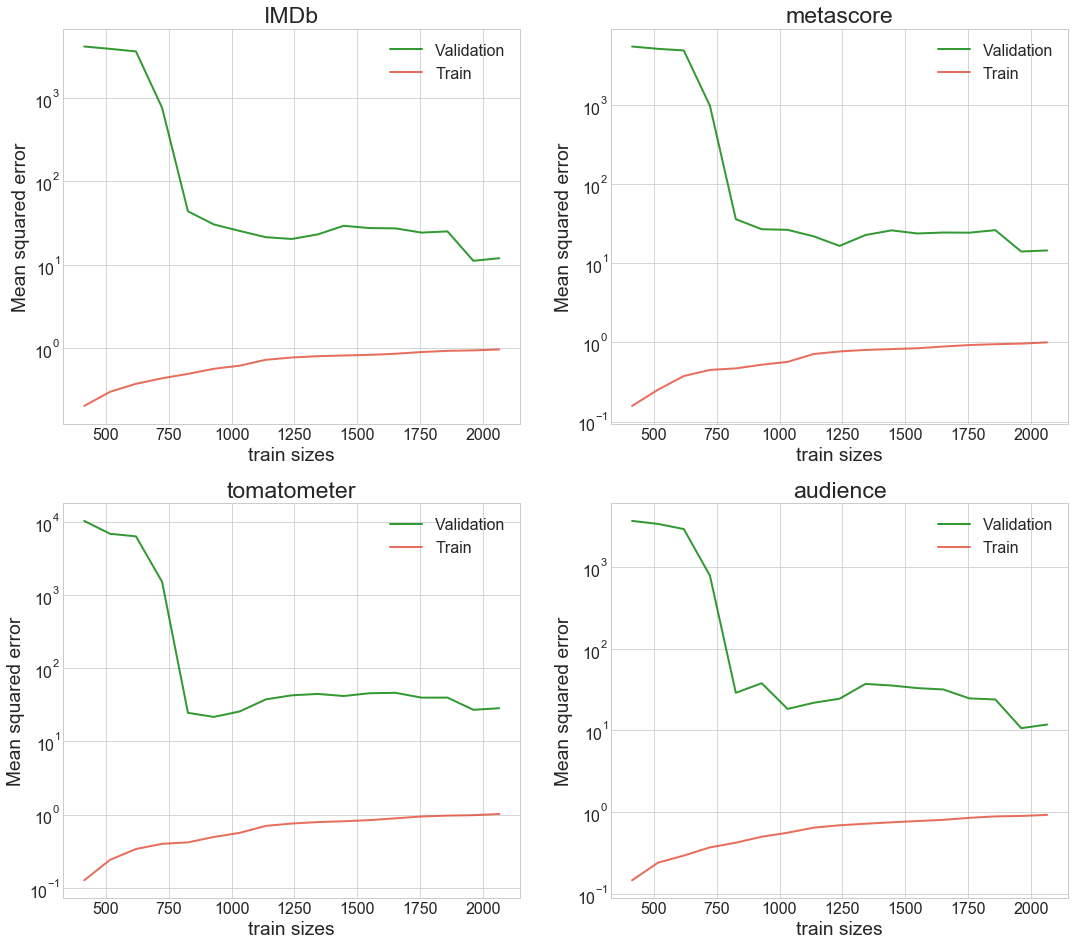

In [741]:
fig, ax = plt.subplots(2,2, figsize=(18,16))

plot_learning_curve_ridge(0,0,0,'IMDb')
plot_learning_curve_ridge(1,0,1,'metascore')
plot_learning_curve_ridge(2,1,0,'tomatometer')
plot_learning_curve_ridge(3,1,1,'audience')

plt.savefig('learn_ridge_comb.png')

In [742]:
def create_val_subplot_ridge(i,row,col,data):
    
    ax[row][col].set_yscale('log')
    ax[row][col].set_xscale('log')
    ax[row][col].plot(mse_scores_val_ridge[i]['Train'])
    ax[row][col].plot(mse_scores_val_ridge[i]['Validation'],color='green')

    ax[row][col].set_title(data)
    ax[row][col].legend(loc='upper right')
    ax[row][col].set_ylabel('Mean squared error')
    ax[row][col].set_xlabel('lambda')

In [743]:
def create_val_subplot_lasso(i,row,col,data):
    
    ax[row][col].set_yscale('log')
    ax[row][col].set_xscale('log')
    ax[row][col].plot(mse_scores_val_lasso[i]['Train'])
    ax[row][col].plot(mse_scores_val_lasso[i]['Validation'], color='green')

    ax[row][col].set_title(data)
    ax[row][col].legend(loc='upper right')
    ax[row][col].set_ylabel('Mean squared error')
    ax[row][col].set_xlabel('lambda')

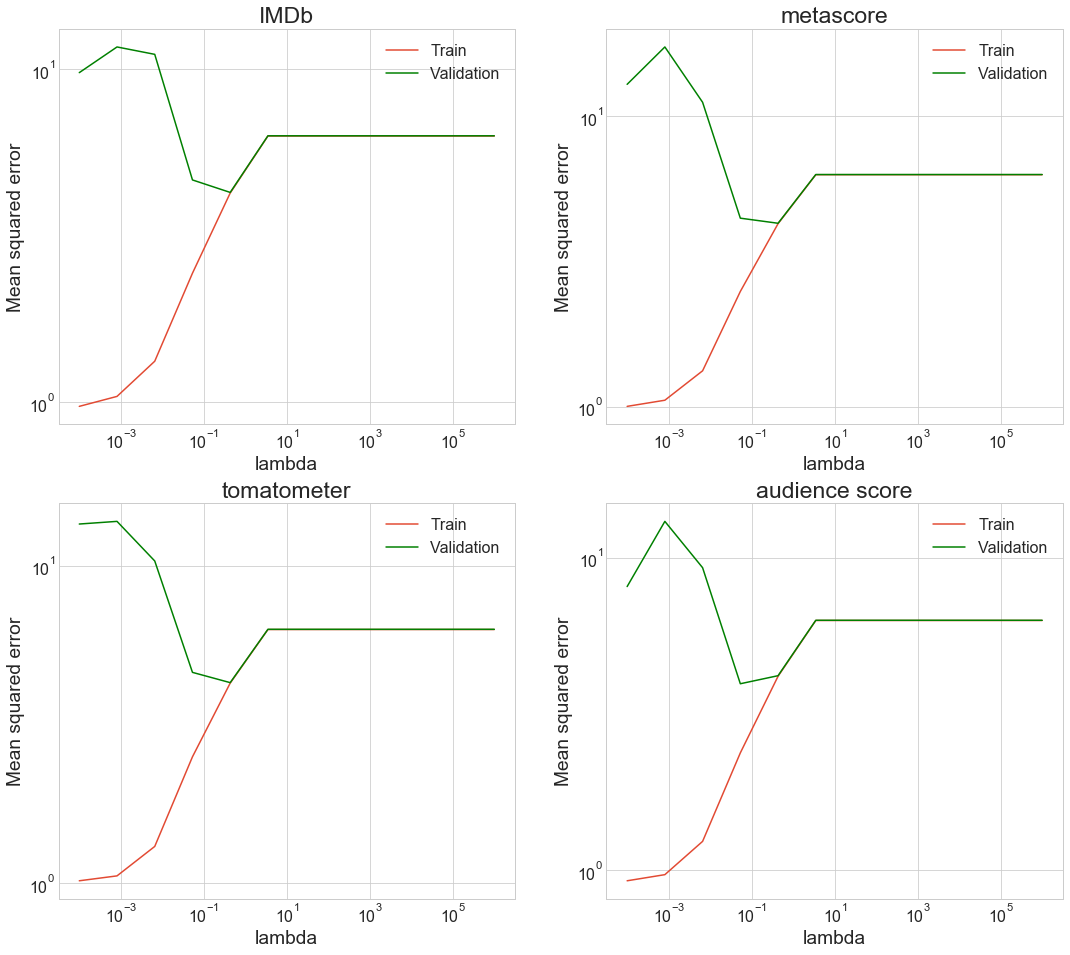

In [744]:
fig, ax = plt.subplots(2,2, figsize=(18,16))

create_val_subplot_lasso(0,0,0,'IMDb')
create_val_subplot_lasso(1,0,1,'metascore')
create_val_subplot_lasso(2,1,0,'tomatometer')
create_val_subplot_lasso(3,1,1,'audience score')

plt.savefig('val_lasso_comb.png')

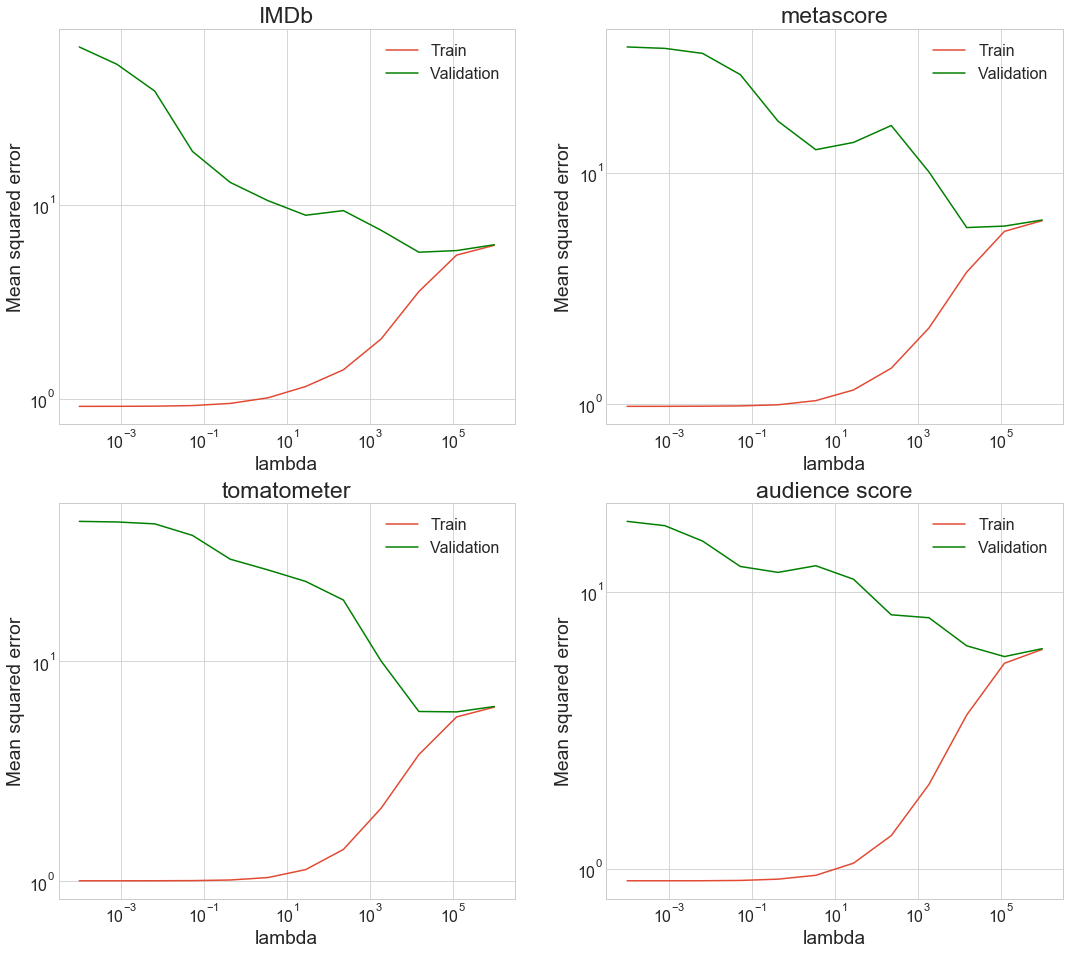

In [745]:
fig, ax = plt.subplots(2,2, figsize=(18,16))

#fig.title('Ridge Model validation curve')

create_val_subplot_ridge(0,0,0,'IMDb')
create_val_subplot_ridge(1,0,1,'metascore')
create_val_subplot_ridge(2,1,0,'tomatometer')
create_val_subplot_ridge(3,1,1,'audience score')

plt.savefig('val_ridge_comb.png')

In [601]:
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(x_imdb, y_norm, test_size=1/3, random_state=1)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(x_meta, y_norm, test_size=1/3, random_state=1)
X_train_tomato, X_test_tomato, y_train_tomato, y_test_tomato = train_test_split(x_tometer, y_norm, test_size=1/3, random_state=1)
X_train_audience, X_test_audience, y_train_audience, y_test_audience = train_test_split(x_audience, y_norm, test_size=1/3, random_state=1)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(x, y_norm, test_size=1/3, random_state=1)


In [711]:
# fit lasso model on imdb

# choose optimal hyperparameter
optimal_lambda_lasso_imdb = mse_scores_val_lasso[0].Validation.nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_lasso_imdb = make_pipeline(PolynomialFeatures(include_bias=False), 
                            StandardScaler(),
                            Ridge(alpha=optimal_lambda_lasso_imdb.index[0], random_state=1))

pipe_lasso_imdb.fit(X_train_imdb,y_train_imdb)
score_lasso_imdb = mse(pipe_lasso_imdb.predict(X_test_imdb),y_test_imdb)
r2_lasso_imdb = r2_score(y_test_imdb, pipe_lasso_imdb.predict(X_test_imdb))

In [712]:
# fit lasso model on metascore

# choose optimal hyperparameter
optimal_lambda_lasso_meta = mse_scores_val_lasso[1].Validation.nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_lasso_meta = make_pipeline(PolynomialFeatures(include_bias=False), 
                            StandardScaler(),
                            Ridge(alpha=optimal_lambda_lasso_meta.index[0], random_state=1))

pipe_lasso_meta.fit(X_train_meta,y_train_meta)
score_lasso_meta = mse(pipe_lasso_meta.predict(X_test_meta),y_test_meta)
r2_lasso_meta = r2_score(y_test_meta, pipe_lasso_meta.predict(X_test_meta))

In [714]:
# fit lasso model on tomatometer

# choose optimal hyperparameter
optimal_lambda_lasso_tomato = mse_scores_val_lasso[2].Validation.nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_lasso_tomato = make_pipeline(PolynomialFeatures(include_bias=False), 
                            StandardScaler(),
                            Ridge(alpha=optimal_lambda_lasso_tomato.index[0], random_state=1))

pipe_lasso_tomato.fit(X_train_tomato,y_train_tomato)
score_lasso_tomato = mse(pipe_lasso_tomato.predict(X_test_tomato),y_test_tomato)
r2_lasso_tomato = r2_score(y_test_tomato, pipe_lasso_tomato.predict(X_test_tomato))

In [715]:
# fit lasso model on audience score

# choose optimal hyperparameter
optimal_lambda_lasso_audience = mse_scores_val_lasso[3].Validation.nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_lasso_audience = make_pipeline(PolynomialFeatures(include_bias=False), 
                            StandardScaler(),
                            Ridge(alpha=optimal_lambda_lasso_audience.index[0], random_state=1))

pipe_lasso_audience.fit(X_train_audience,y_train_audience)
score_lasso_audience = mse(pipe_lasso_audience.predict(X_test_audience),y_test_audience)
r2_lasso_audience = r2_score(y_test_audience, pipe_lasso_audience.predict(X_test_audience))

In [718]:
optimal_lambdas_lasso = [optimal_lambda_lasso_imdb.index[0],optimal_lambda_lasso_meta.index[0],optimal_lambda_lasso_tomato.index[0], optimal_lambda_lasso_audience.index[0]]
lasso_mses = [score_lasso_imdb, score_lasso_meta, score_lasso_tomato, score_lasso_audience]
lasso_r2s = [r2_lasso_imdb, r2_lasso_meta, r2_lasso_tomato, r2_lasso_audience]

df_scores_lasso = pd.DataFrame({'lambda':optimal_lambdas_lasso,
                            'MSE':lasso_mses,
                            'r2':lasso_r2s}, index=['imdb','meta','tomatometer','audience'])
print('Optimal scores for lasso model')
print(df_scores_lasso)

Optimal scores for lasso model
               lambda        MSE        r2
imdb         0.432876  10.918290 -0.810460
meta         0.432876   9.127816 -0.513566
tomatometer  0.432876  12.324941 -1.043710
audience     0.053367   8.476160 -0.405509


In [701]:
# fit ridge model on imdb

# choose optimal hyperparameter
optimal_lambda_ridge_imdb = mse_scores_val_ridge[0].Validation.nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_ridge_imdb = make_pipeline(PolynomialFeatures(include_bias=False), 
                            StandardScaler(),
                            Ridge(alpha=optimal_lambda_ridge_imdb.index[0], random_state=1))

pipe_ridge_imdb.fit(X_train_imdb,y_train_imdb)
score_ridge_imdb = mse(pipe_ridge_imdb.predict(X_test_imdb),y_test_imdb)
r2_ridge_imdb = r2_score(y_test_imdb, pipe_ridge_imdb.predict(X_test_imdb))

Results for imdb ridge:

Optimal lambda in ridge model for is: 15199.11082952933
Resulting MSE and r2: 4.090758582148029 0.3216743533328148
Ridge coefficients are: [ 0.03828336  0.10547015  0.02823943 ... -0.00431202  0.
 -0.01201692]


In [703]:
# fit ridge model on metascore

# choose optimal hyperparameter
optimal_lambda_ridge_meta = mse_scores_val_ridge[1].Validation.nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_ridge_meta = make_pipeline(PolynomialFeatures(include_bias=False), 
                            StandardScaler(),
                            Ridge(alpha=optimal_lambda_ridge_meta.index[0], random_state=1))

pipe_ridge_meta.fit(X_train_meta,y_train_meta)
score_ridge_meta = mse(pipe_ridge_meta.predict(X_test_meta),y_test_meta)
r2_ridge_meta0.4 = r2_score(y_test_meta, pipe_ridge_meta.predict(X_test_meta))

In [708]:
# fit ridge model on tomatometer

# choose optimal hyperparameter
optimal_lambda_ridge_tomato = mse_scores_val_ridge[2].Validation.nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_ridge_tomato = make_pipeline(PolynomialFeatures(include_bias=False), 
                            StandardScaler(),
                            Ridge(alpha=optimal_lambda_ridge_tomato.index[0], random_state=1))

pipe_ridge_tomato.fit(X_train_tomato,y_train_tomato)
score_ridge_tomato = mse(pipe_ridge_tomato.predict(X_test_tomato),y_test_tomato)
r2_ridge_tomato = r2_score(y_test_tomato, pipe_ridge_tomato.predict(X_test_tomato))

In [709]:
# fit ridge model on audience score

# choose optimal hyperparameter
optimal_lambda_ridge_audience = mse_scores_val_ridge[3].Validation.nsmallest(1)

# retrain/re-estimate model using optimal hyperparameters
pipe_ridge_audience = make_pipeline(PolynomialFeatures(include_bias=False), 
                            StandardScaler(),
                            Ridge(alpha=optimal_lambda_ridge_audience.index[0], random_state=1))

pipe_ridge_audience.fit(X_train_audience,y_train_audience)
score_ridge_audience = mse(pipe_ridge_audience.predict(X_test_audience),y_test_audience)
r2_ridge_audience = r2_score(y_test_audience, pipe_ridge_audience.predict(X_test_audience))

In [710]:
optimal_lambdas_ridge = [optimal_lambda_ridge_imdb.index[0],optimal_lambda_ridge_meta.index[0],optimal_lambda_ridge_tomato.index[0], optimal_lambda_ridge_audience.index[0]]
ridge_mses = [score_ridge_imdb, score_ridge_meta, score_ridge_tomato, score_ridge_audience]
ridge_r2s = [r2_ridge_imdb, r2_ridge_meta, r2_ridge_tomato, r2_ridge_audience]
df_scores = pd.DataFrame({'lambda':optimal_lambdas_ridge,
                            'MSE':ridge_mses,
                            'r2':ridge_r2s}, index=['imdb','meta','tomatometer','audience'])
print('Optimal scores for ridge model')
print(df_scores_ridge)

Optimal scores for ridge model
                    lambda       MSE        r2
imdb          15199.110830  4.090759  0.321674
meta          15199.110830  4.234156  0.297896
tomatometer  123284.673944  5.406361  0.103522
audience     123284.673944  5.323387  0.117281


In [588]:
from sklearn.model_selection import RandomizedSearchCV

pipe_el = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        ElasticNet(random_state=1))

gs = RandomizedSearchCV(estimator=pipe_el, 
                  param_distributions={'elasticnet__alpha':np.logspace(-4,4,10)*2,
                              'elasticnet__l1_ratio':np.linspace(0,1,10)}, 
                  scoring='neg_mean_squared_error', 
                  n_jobs=-1,
                  iid=False,
                  cv=5,
                  verbose=10)

In [593]:
output = []

imdb = [X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb]
meta = [X_train_meta, X_test_meta, y_train_meta, y_test_meta]
tomato = [X_train_tomato, X_test_tomato, y_train_tomato, y_test_tomato]
audience = [X_train_audience, X_test_audience, y_train_audience, y_test_audience]
full = [X_train_all, X_test_all, y_train_all, y_test_all]

for data in tqdm([imdb, meta, tomato, audience, full]):
    gs.fit(data[0],data[2])
    output.append([mse(gs.predict(data[1]),data[3]),
    r2_score(data[3], gs.predict(data[1]))])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.4min finished
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  33 tas